In [1]:
import pandas as pd
import numpy as np
import csv
import random as rnd
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
from sklearn import preprocessing
%matplotlib inline

## Read file into dataframe

In [2]:
df = pd.read_csv("regLinPoli2.csv") ##insert your own path

In [3]:
df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X30,X31,X32,X33,X34,X35,X36,X37,X38,y
0,153.782162,23648.953370,2.186906,0.155247,16,-153.782162,-23648.95337,-2.186906,-0.155247,-909.534012,...,272,-1856,1390,-4293,4171,-3493,-290,-1017,9,2.033960e+15
1,645.991251,417304.697100,2.810227,-0.923396,35,-153.782162,-23648.95337,-2.810227,0.923396,343.752475,...,-265,-3587,-2479,-1284,-2127,2369,2657,-1481,-150,4.694470e+19
2,-412.060457,169793.820200,2.614961,0.489764,-25,-153.782162,-23648.95337,-2.614961,-0.489764,-776.331121,...,9,4104,-4634,-1637,-4228,527,-1773,-1676,67,-2.017100e+18
3,35.884351,1287.686648,1.554905,-0.970388,-75,-153.782162,-23648.95337,-1.554905,0.970388,696.736200,...,-215,749,-3645,-3202,-1173,-3248,1888,1295,-49,7.629161e+10
4,-85.073496,7237.499779,1.929794,0.247883,44,-153.782162,-23648.95337,-1.929794,-0.247883,-527.805076,...,-360,2150,507,-1972,-7497,-2427,4368,670,43,-3.225260e+13


## Divide in train and test

In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(df[df.columns[0:-1]],df[[df.columns[-1]]], train_size=0.75)
#print X_train.columns.values


### I recommend that after manipulating data using pandas and before modelling to convert dataframes into arrays. This may avoid some headaches

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(df[df.columns[0:-1]],df[[df.columns[-1]]], train_size=0.75)
#print X_train.columns.values

X_train=np.asarray(X_train)
X_test=np.asarray(X_test)
Y_train=np.asarray(Y_train)
Y_test=np.asarray(Y_test)

## Procedure for data standardizing

In [6]:
# This procedure is useful for classroom examples. For a real implementation you have to have a separete method 
# for transforming the production data so you can transform it as you get it with the fitted scaler
## The procedure returns a standardized copy of the input data
def normalize(X_train,X_test,Y_train,Y_test,do=True):

    scale_X=preprocessing.StandardScaler()
    scale_y=preprocessing.StandardScaler()
    
    train_X=np.copy(X_train)
    train_y=np.copy(Y_train)
    test_X=np.copy(X_test)
    test_y=np.copy(Y_test)
    if do:
        scale_X.fit(train_X)
        scale_y.fit(train_y)
        train_X=scale_X.transform(train_X)
        train_y=scale_y.transform(train_y)
        test_X=scale_X.transform(test_X)
        test_y=scale_y.transform(test_y)
    return train_X,test_X, train_y, test_y

## Incremental regularized regression procedures

In [7]:
## Transfer function
def salida(w,X):
    return X.dot(w[1:]) +w[0]


In [8]:
## Training function
def entrena(X,y,w,la=0.0,eta=0.01):
    
    for i in range(len(X)):
        error=y[i]-salida(w,X[i])
        w[0]=w[0]+eta*(error)
        w[1:]=w[1:]+eta*(error*X[i])-la*w[1:]
    return w


## Error function

In [9]:
def calcError(X,y,w,w0):
    return np.mean((X.dot(w)+w0-y)**2)

## Use

In [10]:
train_X,test_X,train_y,test_y=normalize(X_train,X_test,Y_train,Y_test)

In [11]:
iterations = 100

w=np.asarray([rnd.random() for i in range(1+len(train_X[0]))])
for i in range(iterations):
    w=entrena(train_X,train_y,w,la=0.00)

In [12]:
## flatten here to convert y from a matrix to a vector. Only 1 response variable
print calcError(train_X,train_y.flatten(),w[1:],w[0])
print calcError(test_X,test_y.flatten(),w[1:],w[0])

0.505198963007
0.705763246755


In [13]:
def kFold(k, lmbda, train):
    #Split into k folds:
    split = np.array_split(train, k)
    
    validationError = 0
    learningError = 0
    for i in range(k):
        #Set validation set
        validation = split[i]
        #Set learning set
        learning = np.concatenate([j for index,j in enumerate(split) if i<>index])

        #Assign X and Y
        learning_X = learning[:,0:-1]
        learning_Y = learning[:,-1]
        validation_X = validation[:,0:-1]
        validation_Y = validation[:,-1]

        #Normalize the data    
        learning_X = np.asarray(learning_X)
        learning_Y = np.asarray(learning_Y).reshape(-1, 1)
        validation_X = np.asarray(validation_X)
        validation_Y = np.asarray(validation_Y).reshape(-1, 1)

        learning_X, validation_X,learning_Y, validation_Y = normalize(learning_X, validation_X,learning_Y, validation_Y)

        w = np.asarray([rnd.random() for i in range(1+len(learning_X[0]))])
        iterations = 100

        for i in range(iterations):
            w = entrena(learning_X,learning_Y,w,la=lmbda)

        validationError += calcError(validation_X,validation_Y.flatten(),w[1:],w[0])
        learningError += calcError(learning_X,learning_Y.flatten(),w[1:],w[0])


    averageValidationError = validationError/k
    averageLearningError = learningError/k
    return averageValidationError,averageLearningError,w

In [32]:
train, test = train_test_split(df,test_size=0.25)

train = np.asarray(train)
test = np.asarray(test)

train_x = train[:,0:-1]
train_y = train[:,-1]
test_x = test[:,0:-1]
test_y = test[:,-1]

train_x = np.asarray(train_x)
train_y = np.asarray(train_y).reshape(-1, 1)
test_x = np.asarray(test_x)
test_y = np.asarray(test_y).reshape(-1, 1)

train_x, test_x,train_y, test_y = normalize(train_x, test_x,train_y, test_y)


#lambdas = np.linspace(0, 1.5, num=20)
lambdas = [0.0, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.02]

ave = []
ale = []

for i in lambdas:
    averageValidationError,averageLearningError,w = kFold(5, i, train)
    ave.append(averageValidationError)
    ale.append(averageLearningError)
    testError = calcError(test_x,test_y.flatten(),w[1:],w[0])
    print "For lambda = {}, Average Validation Error: {}, Test Error : {}".format(i,averageValidationError, testError)




For lambda = 0.0, Average Validation Error: 0.6495954381, Test Error : 0.578003297784
For lambda = 0.0005, Average Validation Error: 0.638046880851, Test Error : 0.555608491309
For lambda = 0.001, Average Validation Error: 0.62969842576, Test Error : 0.562251459309
For lambda = 0.002, Average Validation Error: 0.619855167175, Test Error : 0.57891180628
For lambda = 0.005, Average Validation Error: 0.619251390198, Test Error : 0.637075124788
For lambda = 0.01, Average Validation Error: 0.649221219514, Test Error : 0.723448699232
For lambda = 0.02, Average Validation Error: 0.715695178912, Test Error : 0.835809885767


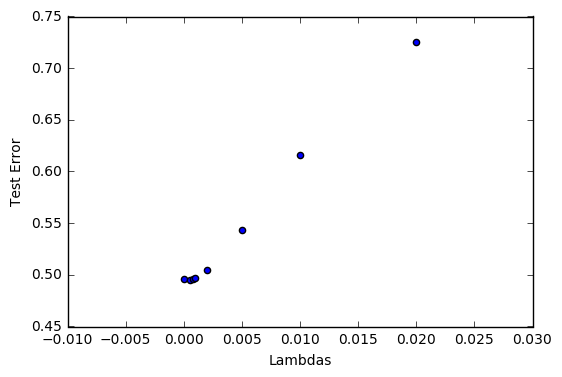

In [30]:
plt.scatter(lambdas, ale)
plt.xlabel('Lambdas')
plt.ylabel('Test Error')
plt.show()